To reveal coordination or co-regulation patterns between genes by constructing a similarity network based on how similarly their expression-accessibility agreement patterns evolve across time.

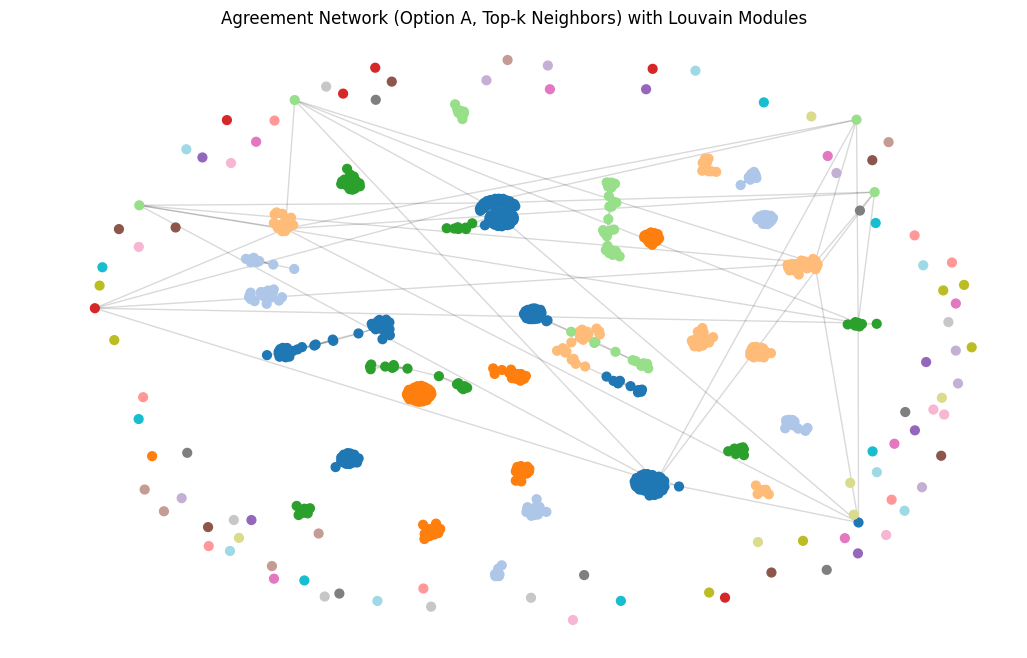

Module composition (by agreement_class):
agreement_class  accessibility_only  conflict  expr_acc_down  expr_acc_up  \
louvain_A                                                                   
0                                32         0              0            0   
1                                83         0              0            0   
2                                 0         0              0            0   
3                                41         3              0            0   
4                                 0         0              0            0   
...                             ...       ...            ...          ...   
127                               1         0              0            0   
128                               0         0              0            0   
129                               1         0              0            0   
130                               0         0              0            0   
131                               1

In [5]:
import pandas as pd
import ast
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain  # pip install python-louvain

# 1. Load and parse lists
data = pd.read_csv("data/green_monkey/all_structure_files/chr1/chr1_feature_agreement_summary.csv")
data['expr_dir'] = data['expr_dir'].apply(ast.literal_eval)
data['acc_tss_dir'] = data['acc_tss_dir'].apply(ast.literal_eval)
data['dir_vector'] = data.apply(lambda row: row['expr_dir'] + row['acc_tss_dir'], axis=1)

# 2. Encode directions as integers
le = LabelEncoder()
le.fit(['down', 'flat', 'up', 'na'])
X = np.array([le.transform(vec) for vec in data['dir_vector']])

# 3. Cosine similarity matrix
sim_matrix = cosine_similarity(X)
genes = data['gene_name'].tolist()

# 4. Build top-k nearest neighbor network
k = 5  # You can adjust k: try 3, 5, 7, or 10 for your data

G = nx.Graph()
G.add_nodes_from(genes)
for i in range(len(genes)):
    # Get indices of top k most similar (excluding self)
    sorted_idx = np.argsort(-sim_matrix[i, :])
    for j in sorted_idx[1:k+1]:  # skip self (i)
        if i < j:  # Avoid duplicate edges
            G.add_edge(genes[i], genes[j], weight=sim_matrix[i, j])

# 5. Louvain clustering
partition = community_louvain.best_partition(G)
data['louvain_A'] = [partition.get(g, -1) for g in genes]

# 6. Visualization
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(13, 8))
colors = [data['louvain_A'][i] for i, node in enumerate(G.nodes())]
nx.draw_networkx_edges(G, pos, alpha=0.15)
nx.draw_networkx_nodes(G, pos, node_size=40, node_color=colors, cmap='tab20')
plt.title('Agreement Network (Option A, Top-k Neighbors) with Louvain Modules')
plt.axis('off')
plt.show()

# 7. Cluster/category summary
if 'agreement_class' in data.columns:
    print("Module composition (by agreement_class):")
    print(pd.crosstab(data['louvain_A'], data['agreement_class']))
else:
    print("Module size summary:")
    print(data['louvain_A'].value_counts())


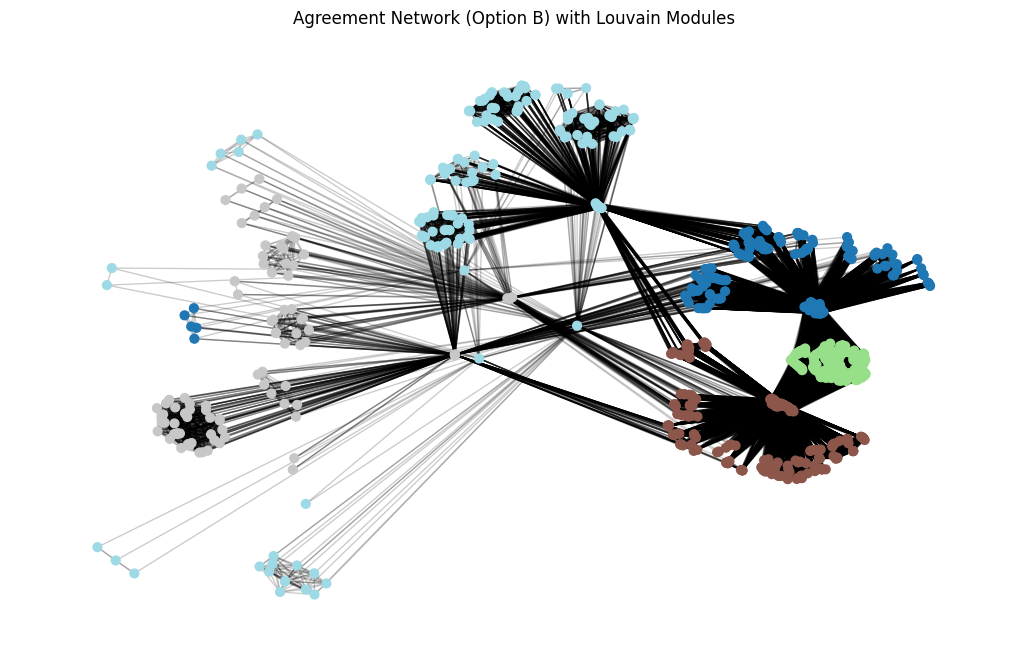

Module composition (by agreement_class):
agreement_class  accessibility_only  conflict  expr_acc_down  expr_acc_up  \
louvain_B                                                                   
0                                88         0              0            0   
1                               165         0              0            0   
2                               116         0              0            0   
3                                 0        40              0            0   
4                                 0         0              9            1   

agreement_class  expression_only  mixed  stable  
louvain_B                                        
0                             13     61      13  
1                              0      0       0  
2                             17     62      27  
3                              2     20      25  
4                              7    136       0  


In [2]:
from sklearn.preprocessing import MultiLabelBinarizer

data['agreement_vec'] = data['expr_acc_tss_agreement'].apply(ast.literal_eval)
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(data['agreement_vec'])

sim_matrix = cosine_similarity(X)
G2 = nx.Graph()
G2.add_nodes_from(genes)
threshold = 0.7
for i in range(len(genes)):
    for j in range(i + 1, len(genes)):
        if sim_matrix[i, j] > threshold:
            G2.add_edge(genes[i], genes[j], weight=sim_matrix[i, j])

partition2 = community_louvain.best_partition(G2)
data['louvain_B'] = [partition2.get(g, -1) for g in genes]

pos = nx.spring_layout(G2, seed=42)
plt.figure(figsize=(13, 8))
colors = [data['louvain_B'][i] for i, node in enumerate(G2.nodes())]
nx.draw_networkx_nodes(G2, pos, node_size=40, node_color=colors, cmap='tab20')
nx.draw_networkx_edges(G2, pos, alpha=0.2)
plt.title('Agreement Network (Option B) with Louvain Modules')
plt.axis('off')
plt.show()

if 'agreement_class' in data.columns:
    print("Module composition (by agreement_class):")
    print(pd.crosstab(data['louvain_B'], data['agreement_class']))
else:
    print("Module size summary:")
    print(data['louvain_B'].value_counts())
